From tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from methods import *
from utils import *

# Choice of Model to Attack
- LeNet5: MNIST
- Basic CNN: Fashion MNIST
- ResNet20: CIFAR-10
### Run **ONE** of the following 3 cells

In [2]:
from models.LeNet import *
target_mdl = LeNet("models/lenet_mnist_model.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader
mdl_name='MNIST'

In [3]:
from models.simple_FashionMNIST import *
target_mdl = simple_FashionMNIST("models/simple_FashionMNIST.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader
mdl_name = 'FMNIST'

Running on cpu.
Model weights loaded successfully


In [4]:
from models.resNet import ResNet20
target_mdl = ResNet20()
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader
mdl_name = 'ResNet'

Using cache found in C:\Users\JIC/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


# Algorithim Comparison

In [5]:
hist_dfs = []
final_hist_dfs = []
hist = None

debug = True
targeted = True
epsilon = 0.005
ex_savers = [] # can be used to visualize attacks
algs = ['fw', 'fw_away', 'fw_pair'] # options: 'fw', 'fw_momentum', 'fw_away', 'fw_pair'
#algs = ['fw']
fw_stepsize_rule = 'decay' # options: 'decay', 'amjo', 'ls'
for alg in algs:
    ex_saver = example_saver()
    acc, ex, hist = test(target_mdl, device,
                         epsilon = epsilon, 
                         num_fw_iter = 20,
                         method = alg, 
                         early_stopping = 'gap_FW', 
                         fw_stepsize_rule = fw_stepsize_rule, 
                         gap_FW_tol = 1E-1,
                         targeted = targeted, 
                         num_test = 500, 
                         ex_saver=ex_saver,
                         norm_p=-1, # -1 for infnty norm, 2 for L2
                         seed=11)
    ex_savers.append(ex_saver)
    hist_dfs.append(hist)
    final_hist = hist.groupby('example_idx').tail(1)
    final_hist_dfs.append(final_hist) # hist with just the rows of last FW iters
final_hist_dfs[-1]

  5%|▌         | 532/10000 [01:45<31:17,  5.04it/s]


Epsilon: 0.005	Correct Classifications (Failed Attacks) = 163 / 500 = 0.326


  5%|▌         | 532/10000 [02:10<38:34,  4.09it/s]  


Epsilon: 0.005	Correct Classifications (Failed Attacks) = 165 / 500 = 0.33


  5%|▌         | 532/10000 [02:19<41:29,  3.80it/s]  

Epsilon: 0.005	Correct Classifications (Failed Attacks) = 169 / 500 = 0.338


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,adv_target,gap_AS,A_t,l_inf,mdlLoss,targeted_success
19,0,20,0.144464,True,False,9,8,max_iter,8,0.072357,"[0.04711779448621553, 0.16666666666666663, 0.1...",0.005,0.847962,True
39,1,20,0.140389,False,False,6,6,max_iter,8,0.079774,"[0.16666666666666663, 0.16666666666666666, 0.0...",0.005,6.236699,False
59,2,20,0.314945,False,False,0,0,max_iter,8,0.126811,"[0.02521008403361344, 0.18181818181818182, 0.1...",0.005,3.380095,False
65,3,6,0.053495,True,False,1,9,gap,9,0.023805,"[0.04761904761904767, 0.09999999999999998, 0.4...",0.005,0.080469,True
69,4,4,0.049490,True,False,7,3,gap,3,0.021332,"[0.16666666666666663, 0.5, 0.33333333333333337]",0.005,0.013404,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6700,495,17,0.088807,True,False,6,0,gap,0,0.028490,"[0.04166666666666663, 0.2857142857142857, 0.08...",0.005,0.149602,True
6712,496,12,0.087020,True,False,2,4,gap,4,0.010755,"[0.2181818181818182, 0.16666666666666663, 0.03...",0.005,0.040249,True
6721,497,9,0.070424,True,False,9,2,gap,2,0.028694,"[0.16666666666666663, 0.2857142857142857, 0.25...",0.005,0.052088,True
6741,498,20,0.403625,False,False,9,9,max_iter,6,0.439073,"[0.23333333333333336, 0.11904761904761904, 0.0...",0.005,7.011263,False


fw
	Targeted Attack Success Rate: 0.654
	Avg iters: 12.78
fw_away
	Targeted Attack Success Rate: 0.646
	Avg iters: 12.9
	Step Types: FW 5399, AS 1051. 16.3% Away Steps.
fw_pair
	Targeted Attack Success Rate: 0.624
	Avg iters: 13.524


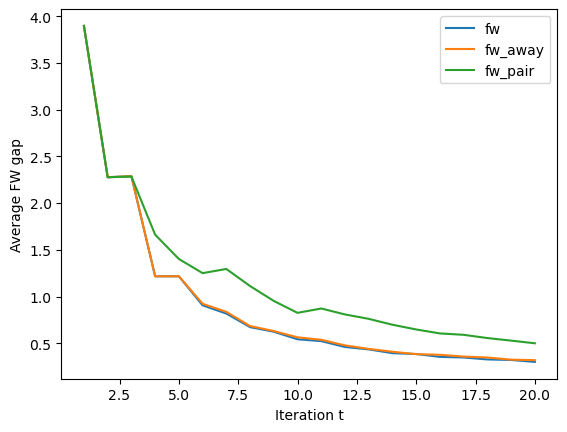

In [7]:
plot_convergence(hist_dfs, algs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


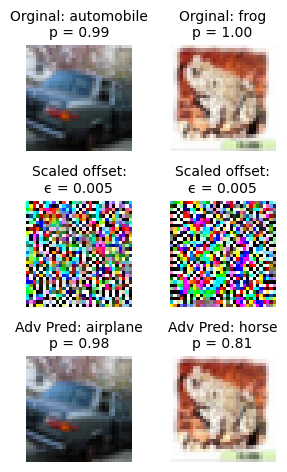

In [8]:
display_examples(ex_savers[0], epsilon, target_mdl.classes, show_atk_mag=False, n_col=2, offset=8)

# Step-Size Comparison

In [46]:
hist_dfs = []
final_hist_dfs = []
hist = None

debug = True
targeted = True
epsilon = 0.005
ex_savers = []
alg = 'fw_pair' # 'fw_away', 'fw_pair']
rules = ['decay', 'amjo', 'ls']
for step_rule in rules:
    fw_stepsize_rule = step_rule
    ex_saver = example_saver()
    acc, ex, hist = test(target_mdl, device,
                         epsilon = epsilon, 
                         num_fw_iter = 20,
                         method = alg, 
                         early_stopping = 'gap_FW', 
                         fw_stepsize_rule = fw_stepsize_rule, 
                         gap_FW_tol = 1E-1,
                         targeted = targeted, 
                         num_test = 500, 
                         ex_saver=ex_saver,
                         norm_p=-1, # -1 for infnty norm
                         seed=11)
    ex_savers.append(ex_saver)
    hist_dfs.append(hist)
    final_hist = hist.groupby('example_idx').tail(1)
    final_hist_dfs.append(final_hist) # hist with just the rows of last FW iters
final_hist_dfs[-1]

  5%|▌         | 532/10000 [01:59<35:25,  4.45it/s]


Epsilon: 0.005	Correct Classifications (Failed Attacks) = 169 / 500 = 0.338


  5%|▌         | 532/10000 [03:28<1:01:46,  2.55it/s]


Epsilon: 0.005	Correct Classifications (Failed Attacks) = 168 / 500 = 0.336


  5%|▌         | 532/10000 [25:42<7:37:35,  2.90s/it] 

Epsilon: 0.005	Correct Classifications (Failed Attacks) = 171 / 500 = 0.342


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,adv_target,gap_AS,A_t,l_inf,mdlLoss,targeted_success
19,0,20,0.137753,False,False,9,9,max_iter,8,0.063549,"[0.0026509247999999958, 0.09527961600000001, 0...",0.005,1.158775,False
39,1,20,0.091901,False,False,6,6,gap,8,0.028470,"[0.08942400000000002, 0.1472, 0.0767771136, 0....",0.005,6.258967,False
59,2,20,0.314857,False,False,0,0,max_iter,8,0.145597,"[0.10084838399999999, 0.192192, 0.009884160000...",0.005,3.298673,False
64,3,5,0.065985,True,False,1,9,gap,9,0.023003,"[0.30464, 0.068, 0.35200000000000004, 0.132, 0...",0.005,0.092356,True
68,4,4,0.001700,True,False,7,3,gap,3,0.000537,"[0.0464, 0.42000000000000004, 0.5336]",0.005,0.000648,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442,495,16,0.090515,True,False,6,0,gap,0,0.049937,"[0.019036159999999996, 0.084448, 0.131328, 0.1...",0.005,0.184753,True
6450,496,8,0.091748,True,False,2,4,gap,4,0.043364,"[0.33924383999999996, 0.09689856, 0.0831999999...",0.005,0.073029,True
6460,497,10,0.080884,True,False,9,2,gap,2,0.048869,"[0.31552, 0.16, 0.021525504, 0.040000000000000...",0.005,0.079810,True
6480,498,20,0.250309,False,False,9,9,max_iter,6,0.239383,"[0.21672, 0.006451199999999997, 0.066, 0.0608,...",0.005,6.498106,False


decay
	Targeted Attack Success Rate: 0.624
	Avg iters: 13.524
amjo
	Targeted Attack Success Rate: 0.636
	Avg iters: 13.138
ls
	Targeted Attack Success Rate: 0.638
	Avg iters: 12.998


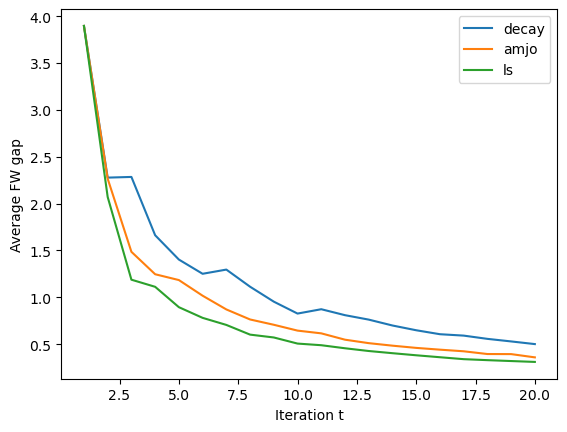

In [58]:
plot_convergence(hist_dfs, rules)

9
8
8


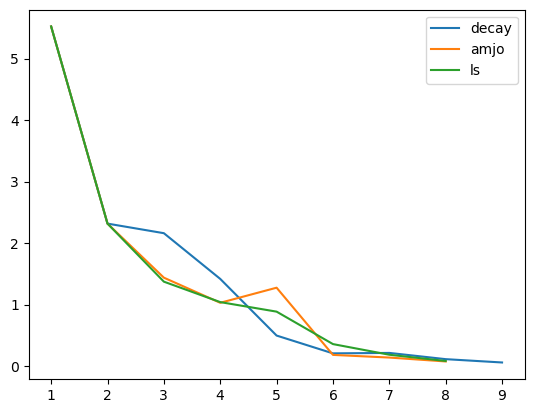

In [49]:
# visualize attack on one example (other plots are averaged across all examples, which can be misleading due to early convergence)
ex_idx = 5
for i, df in enumerate(hist_dfs):
    single_ex = df[df['example_idx'] == ex_idx]
    print(len(single_ex))
    plt.plot(single_ex['FW_iter'], single_ex['gap_FW'], label=rules[i])

plt.legend()

decay
	Targeted Attack Success Rate: 0.63
	Avg iters: 13.26
amjo
	Targeted Attack Success Rate: 0.66
	Avg iters: 12.94
ls
	Targeted Attack Success Rate: 0.63
	Avg iters: 12.81


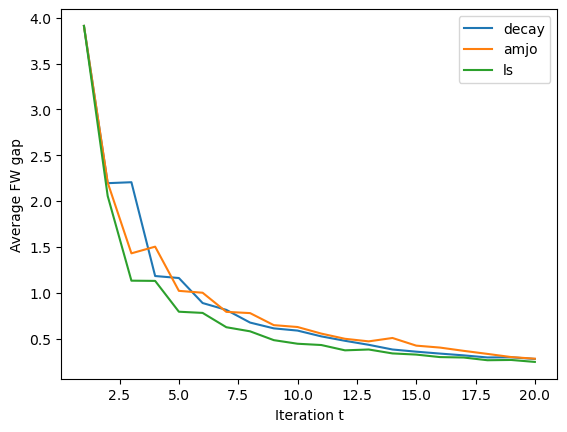

In [7]:
# gamma = 0.5
# delta = 0.5
# 'fw'
# 100 examples CIFAR10 eps = 0.005 targeted
plot_convergence(hist_dfs, rules)

decay
	Targeted Attack Success Rate: 0.62
	Avg iters: 13.33
amjo
	Targeted Attack Success Rate: 0.64
	Avg iters: 13.04
ls
	Targeted Attack Success Rate: 0.63
	Avg iters: 12.87


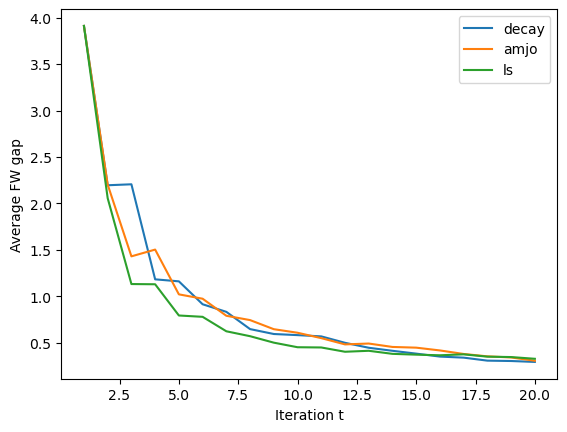

In [7]:
# gamma = 0.5
# delta = 0.5
# 'fw_away'
# 100 examples CIFAR10 eps = 0.005 targeted
plot_convergence(hist_dfs, rules)

decay
	Targeted Attack Success Rate: 0.62
	Avg iters: 13.96
amjo
	Targeted Attack Success Rate: 0.62
	Avg iters: 13.46
ls
	Targeted Attack Success Rate: 0.61
	Avg iters: 13.5


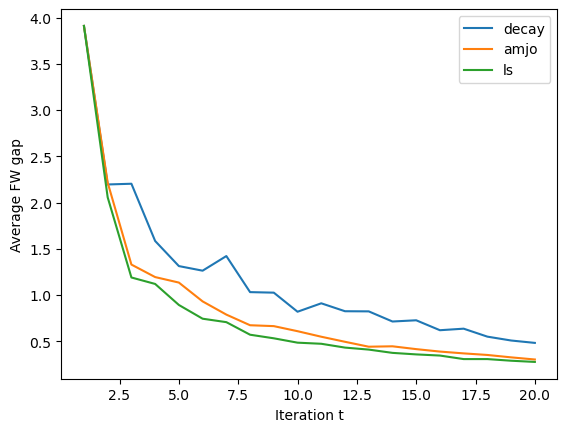

In [14]:
# gamma = 0.5
# delta = 0.5
# 'fw_pair'
# 100 examples CIFAR10 eps = 0.005 targeted
plot_convergence(hist_dfs, step_rules)

decay
	Targeted Attack Success Rate: 0.654
	Avg iters: 12.78
ls
	Targeted Attack Success Rate: 0.65
	Avg iters: 12.336
amjo
	Targeted Attack Success Rate: 0.664
	Avg iters: 12.776


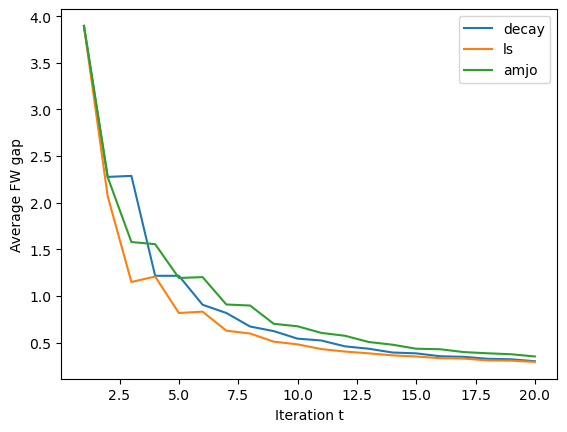

In [35]:
dfs = []
rules = ['decay', 'ls', 'amjo']
for rule in rules:
    df = pd.read_csv(f"Report/Results/hist_{rule}.tsv", sep='\t')
    dfs.append(df)
rule_hist = pd.concat(dfs)
plot_convergence(dfs,rules)

Epsilion choice analysis

In [11]:
with open('Report/Results/eps_compare.tsv','a') as f:
    header = ['eps', 'alg', 'SR', 'DS', 'targeted']
    targeted = False
    #f.write('\t'.join(header)+'\n')
    for i, df in enumerate(final_hist_dfs):
        f.write('\t'.join([str(epsilons[i]), alg, str(df['success'].mean()), mdl_name, str(targeted)])+'\n')

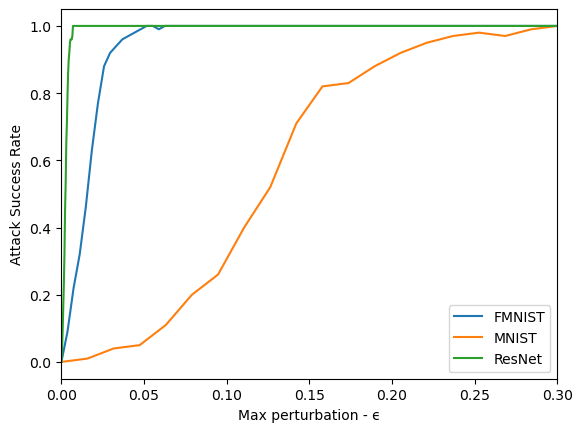

In [35]:
eps_df = pd.read_csv('Report/Results/eps_compare.tsv', sep='\t')
for ds in eps_df['DS'].unique():
    df = eps_df[eps_df['DS'] == ds]
    #df = df[df['eps'] <= 0.3]
    plt.plot(df['eps'], df['SR'], label=ds)
plt.xlim((0,0.3))
plt.legend()
plt.xlabel('Max perturbation - ϵ')
plt.ylabel('Attack Success Rate')
plt.savefig('Report/plots/eps_choice.png')
plt.show()


In [10]:
final_hist_dfs[1].groupby('stop_cond').size()

stop_cond
gap         30
max_iter    20
dtype: int64

In [19]:
final_hist.groupby('success')['gap_FW'].mean()

success
False    0.414841
True     0.106524
Name: gap_FW, dtype: float64

Mean FW iterations: 13.35


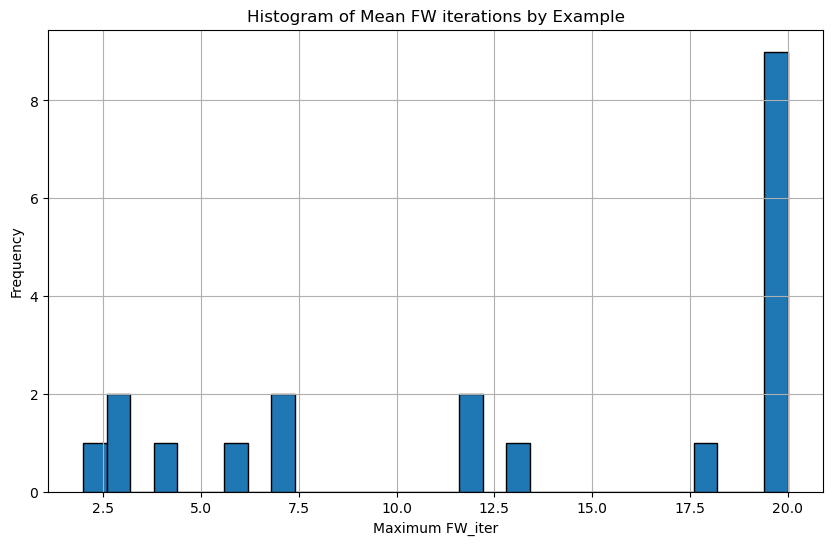

In [9]:
num_iters = hist_dfs[0].groupby('example_idx')['FW_iter'].max()
print(f"Mean FW iterations: {num_iters.mean()}")
plt.figure(figsize=(10, 6))
num_iters.plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Mean FW iterations by Example')
plt.xlabel('Maximum FW_iter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()